In [1]:
import pandas as pd
import numpy as np

import glob
from ase.io import read
from dscribe.descriptors import ACSF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

from pandas import set_option
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
def ML_train(X_tr, y_tr, X_te, y_te):
    rstate = random.randrange(1,999999999,1)
    estimator = RandomForestRegressor(random_state = rstate, n_estimators = 10, n_jobs = 12)
    train = estimator.fit(X_tr, y_tr)
    pred = estimator.predict(X_te)
    
    # Cross validation 
    cvscore = cross_val_score(estimator, X_tr, y_tr, cv=5)
    score = cvscore.mean()
    print("Score with the entire dataset = %.2f" % score)
    
    print(mean_absolute_error(y_te, pred))
    print(mean_squared_error(y_te,pred))
    print(r2_score(y_te, pred))
    return estimator

In [3]:
def calc_sym(pdb_file, chg_file):
    structure = read("pdb/"+pdb_file)
    feat_lst=[]
    num=structure.get_global_number_of_atoms()
    atomPos = [x for x in range(0,num)]

    chg=np.genfromtxt("charge/"+chg_file)


    for r_cut in [x/2. for x in range(2,13,1)]:
        # Setting up the ACSF descriptor
        acsf = ACSF(
            species=["C", "H", "O", "N", "Ca"],
            rcut=r_cut,
            g2_params=[[0.0001,0]],
        )
        feat_lst.append(acsf.create(structure,positions=atomPos,n_jobs=4))

    acsf_ang = ACSF(
        species=["C", "H", "O", "N", "Ca"],
        rcut=3.0,
        g4_params=[[0.0001,0.5,-1]],
    )
    feat_lst.append(acsf_ang.create(structure,positions=atomPos,n_jobs=4))
    
    feat = np.hstack(tuple(feat_lst))
    dat = np.hstack((feat,chg))
    np.savetxt('sym/sym_'+pdb_file[0:-4]+'.dat', dat, delimiter=',')  
    return dat

In [ ]:
testsize = 0.3

# Machine learning function
def RFR_atom(ele_data):
    rstate = random.randrange(1,999999999,1)
    X = ele_data[:,:-2]
    y = ele_data[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testsize, random_state = rstate)
    estimator = ML_train(X_train, y_train, X_test, y_test)
    return estimator

In [4]:
# Use all the files
loops = glob.glob("pdb/*.pdb")
structures = list()
all_feat=[]
for loop in loops:
    name = loop.split('/')[1].split('.pdb')[0]
    all_feat.append(calc_sym(name+'.pdb',name+'.chg'))
    
allData = np.concatenate(tuple(all_feat))

In [11]:
CA_data = allData[allData[:,-2]==20,:]
C_data = allData[allData[:,-2]==6,:]
N_data = allData[allData[:,-2]==7,:]
O_data = allData[allData[:,-2]==8,:]
H_data = allData[allData[:,-2]==1,:]

In [ ]:
for ele_data in CA_data, C_data, N_data, O_data, H_data:
    print("Training for atoms according to the elements separately")
    

In [180]:
# evaluate measurement of the prediction
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
pred = estimator.predict(X_test)
print("mean absolute error is %.4f" % mean_absolute_error(y_test, pred))
print("mean squared error is %.4f" % mean_squared_error(y_test, pred))
print("r2 score is %.4f" % r2_score(y_test, pred))

mean absolute error is 0.0570
mean squared error is 0.0084
r2 score is 0.6866


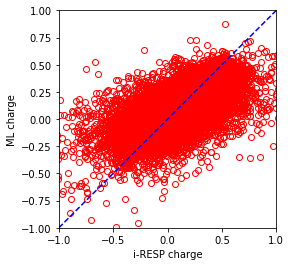

In [184]:
# Plot outputs
import pylab as pl
fig = pl.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
pl.plot(y_test, pred,'ro',fillstyle='none')
pl.xlim(-1,1)
pl.ylim(-1,1)
pl.plot([-1,1],[-1,1], '--b')

pl.xlabel('i-RESP charge')
pl.ylabel('ML charge')
pl.show()

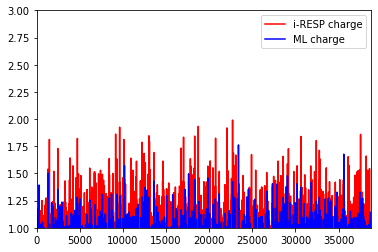

In [149]:
data_size = len(y_test)
fig = pl.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, int(data_size*testsize +3))
ax.set_ylim(1, 3)
pl.plot(y_test, color='red', label = 'i-RESP charge')
pl.plot(pred, color='blue', label = 'ML charge')
pl.legend(loc='best')
pl.show()

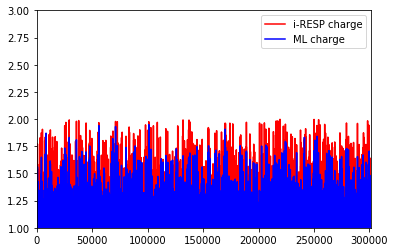

In [150]:
data_size = len(y_train)
fig = pl.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, int(data_size))
ax.set_ylim(1, 3)
pl.plot(y_train, color='red', label = 'i-RESP charge')
pl.plot(estimator.predict(X_train), color='blue', label = 'ML charge')
pl.legend(loc='best')
pl.show()

In [ ]:
# Chopping the data for validation
X_train_total_size = X_train.shape[0]
chunk = 1
chunk_size = int(X_train_total_size / chunk)
for i in range(chunk):
    row = 1 + i*chunk_size + chunk_size
    sub_X_train = X_train[0:row,:]
    sub_y_train = y_train[0:row]
    ML_train(sub_X_train,sub_y_train,X_test,y_test)